# Part 1: Convolutional AutoEncoder

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
import pandas as pd
from network_definition import AutoEncoder
!pip -q install plotly
import plotly.express as px

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

### Setting up Dataset and DataLoader
I want to build my own custom dataset to convert from PIL to Tensors

In [2]:
class CustomDataset(Dataset):
    def __init__(self, list_of_pil_images, transform = None):
        self.transform = transform
        self.data = []
        for j in range(len(list_of_pil_images)):
            
            image = list_of_pil_images[j][0]
            label = list_of_pil_images[j][1]
            self.data.append((image, label))  
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            sample = self.transform(image), torch.tensor(label)
        return sample

In [3]:
torch.manual_seed(0)

train_dataset, val_dataset = train_test_split(train_dataset, train_size = 0.8, test_size = 0.2, random_state = 0) #splitting

train_dataset = CustomDataset(train_dataset, transform = torchvision.transforms.ToTensor())
val_dataset = CustomDataset(val_dataset, transform = torchvision.transforms.ToTensor())
test_dataset = CustomDataset(test_dataset, transform = torchvision.transforms.ToTensor())


batch_size = 500
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [4]:
width = train_dataset.__getitem__(0)[0].shape[2]
height = train_dataset.__getitem__(0)[0].shape[1]

Epoch #1
Average TRAINING loss for this epoch: 0.14072665572166443
Average VALIDATION loss for this epoch: 0.11759480088949203


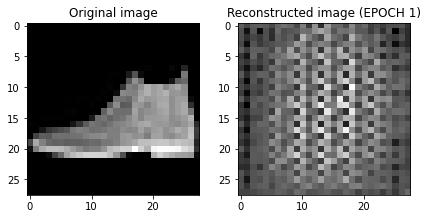

Epoch #2
Average TRAINING loss for this epoch: 0.07806403189897537
Average VALIDATION loss for this epoch: 0.04960287734866142


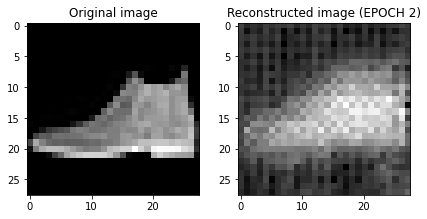

Epoch #3
Average TRAINING loss for this epoch: 0.04451759159564972
Average VALIDATION loss for this epoch: 0.04172194004058838


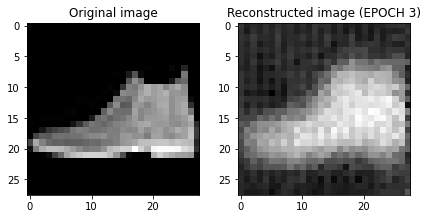

Epoch #4
Average TRAINING loss for this epoch: 0.03992782533168793
Average VALIDATION loss for this epoch: 0.038789208978414536


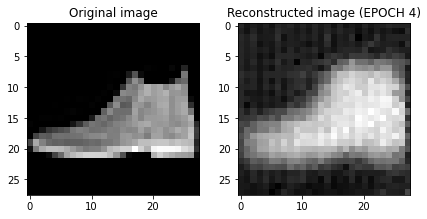

Epoch #5
Average TRAINING loss for this epoch: 0.03774676099419594
Average VALIDATION loss for this epoch: 0.03711391240358353


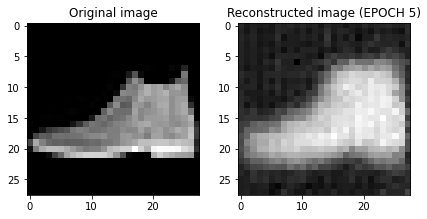

Epoch #6
Average TRAINING loss for this epoch: 0.03643271327018738
Average VALIDATION loss for this epoch: 0.03611554577946663


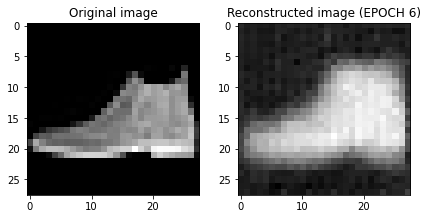

Epoch #7
Average TRAINING loss for this epoch: 0.035630002617836
Average VALIDATION loss for this epoch: 0.03549153730273247


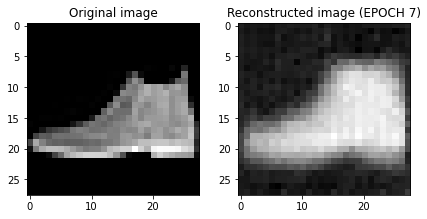

Epoch #8
Average TRAINING loss for this epoch: 0.03504827991127968
Average VALIDATION loss for this epoch: 0.03500461205840111


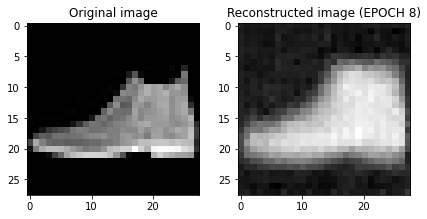

Epoch #9
Average TRAINING loss for this epoch: 0.03461163863539696
Average VALIDATION loss for this epoch: 0.03460652008652687


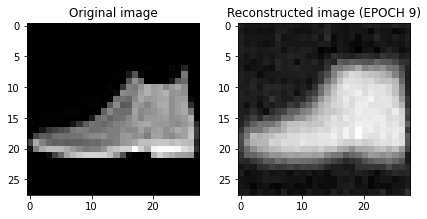

Epoch #10
Average TRAINING loss for this epoch: 0.03420298174023628
Average VALIDATION loss for this epoch: 0.034219369292259216


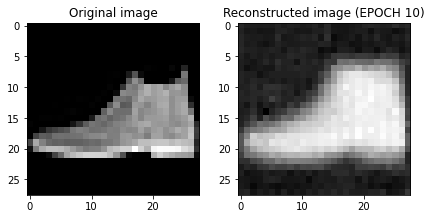

In [5]:
### Set the random seed for reproducible results
torch.manual_seed(0)

autoencoder = AutoEncoder(2)
autoencoder.to(device)
net_settings = {
                'lr' : 5e-4,
                'epochs': 10,
                'optimizer': optim.Adam,
                'loss_fn' : nn.MSELoss()
                }
autoencoder.train_and_validate(net_settings, train_dataloader, val_dataloader, test_dataloader)

## Visualizing network's activity

In [6]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    autoencoder.eval()
    with torch.no_grad():
        encoded_img  = autoencoder.encode(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe...
encoded_samples = pd.DataFrame(encoded_samples)

#... and plot results

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)


100%|██████████| 10000/10000 [00:05<00:00, 1928.33it/s]


## Generate synthetic images

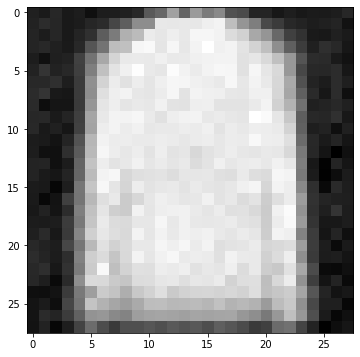

In [7]:
encoded_space_dim = 2
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [20, 30]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    autoencoder.eval()
    with torch.no_grad():
        generated_img  = autoencoder.decode(encoded_value)

    plt.figure(figsize=(9,6))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()